In [1]:
# imports
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
path = "/volatile/zephyr/Ruturaj/cfi_project/test_suite/spec-stripped/"
benchmarks = ["400.perlbench", "401.bzip2", "403.gcc.hs", "445.gobmk", "456.hmmer", \
              "458.sjeng.hs", "464.h264ref.hs"]
binaries = ["perlbench-debug.exe", "bzip2.exe", "gcc.exe", "gobmk.exe", "hmmer.exe", \
            "sjeng.exe", "h264ref.exe"]

clean_dict = {}
callsite_dict = {}
fun_dict = {}

for i, benchmark in enumerate(benchmarks):
    print(benchmark)
    
    clean_df = pd.read_csv(os.path.join(path+benchmark, binaries[i] + "-clean.csv"), index_col=0, header=[0])
    fun_df = pd.read_csv(os.path.join(path+benchmark, binaries[i] + "-fun-clean.csv"), \
                         header=[0])
    callsite_df = pd.read_csv(os.path.join(path+benchmark, binaries[i] + "-callsite-clean.csv"), \
                              index_col=0, header=[0])
    
    ######## Clean clean_df and store. ########
    
    # Drop rows with Nan values. Note: this could remove the ligimate callsites.
    clean_df = clean_df.dropna(how="any")
    
    # Sort the dataframe on "Params".
    clean_df = clean_df.sort_values("Params")
    
    # add SrcType (IFCC)_ida if absent
    if "SrcType (IFCC)_ida" not in clean_df:
        clean_df["SrcType (IFCC)_ida"] = 0
    if "SafeSrcType (IFCC-safe)_ida" not in clean_df:
        clean_df["SafeSrcType (IFCC-safe)_ida"] = 0
        
    # Convert the dataframe type to int (for all the columns).
    columns = ["Params_ida", "SrcType (IFCC)_ida", "SafeSrcType (IFCC-safe)_ida", "BinType (TypeArmor)_ida", \
              "Baseline_ida"]
    clean_df[columns] = clean_df[columns].astype(int)
    
    # Calculate differences in each column.
    clean_df["Param_match"] = np.where(clean_df["Params"] == clean_df["Params_ida"], 1, 0)
    clean_df["SrcType_match"] = np.where(clean_df["SrcType (IFCC)"] == clean_df["SrcType (IFCC)_ida"], 1, 0)
    clean_df["SafeSrcType_match"] = np.where(clean_df["SafeSrcType (IFCC-safe)"] \
                                    == clean_df["SafeSrcType (IFCC-safe)_ida"], 1, 0)
    clean_df["BinType_match"] = np.where(clean_df["BinType (TypeArmor)"] \
                                         == clean_df["BinType (TypeArmor)_ida"], 1, 0)
    
    clean_dict[benchmark] = clean_df
    
    ######## Clean callsite_df and store. ########
    
    # Drop rows with Nan values. Note: this could remove the ligimate callsites.
    callsite_df = callsite_df.dropna(how="any")
    
    # Convert the dataframe type to int (for all the columns).
    columns = ["Arg1_ida", "Arg2_ida", "Arg3_ida", "Arg4_ida", "Arg5_ida", \
               "Arg6_ida", "Arg7_ida", "Return_ida"]
    callsite_df[columns] = callsite_df[columns].astype(int)
    
    callsite_dict[benchmark] = callsite_df
    
    ######## Clean fun_df and store. ########
    
    fun_dict[benchmark] = fun_df

400.perlbench
401.bzip2
403.gcc.hs
445.gobmk
456.hmmer
458.sjeng.hs
464.h264ref.hs


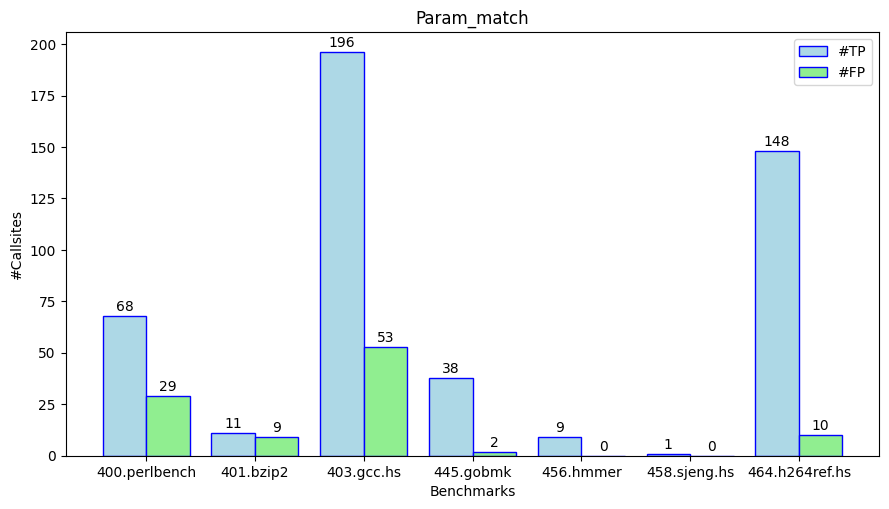

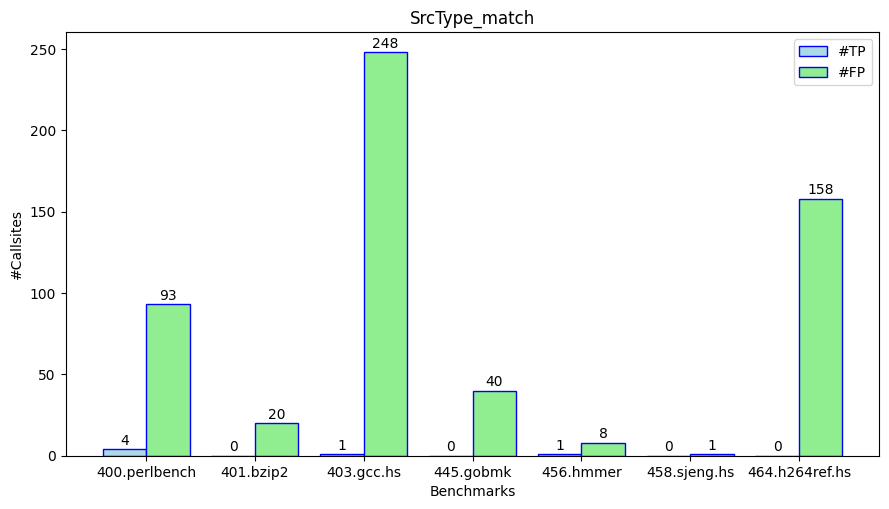

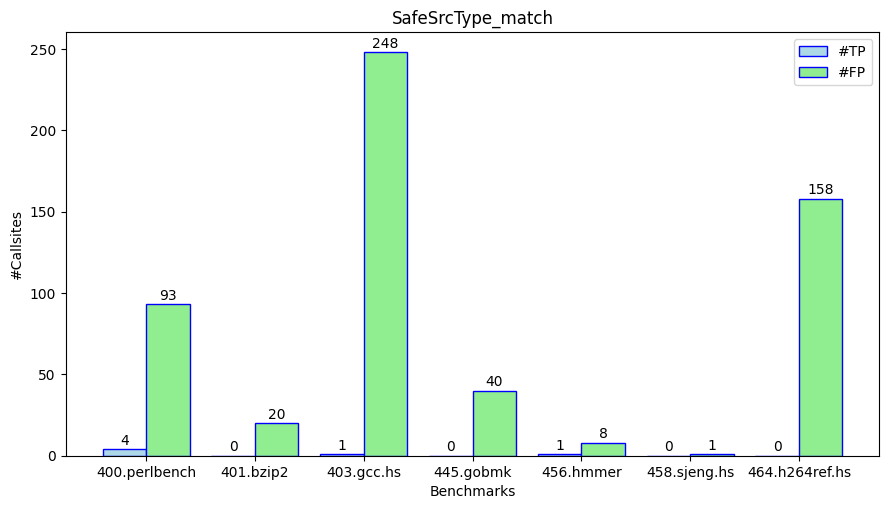

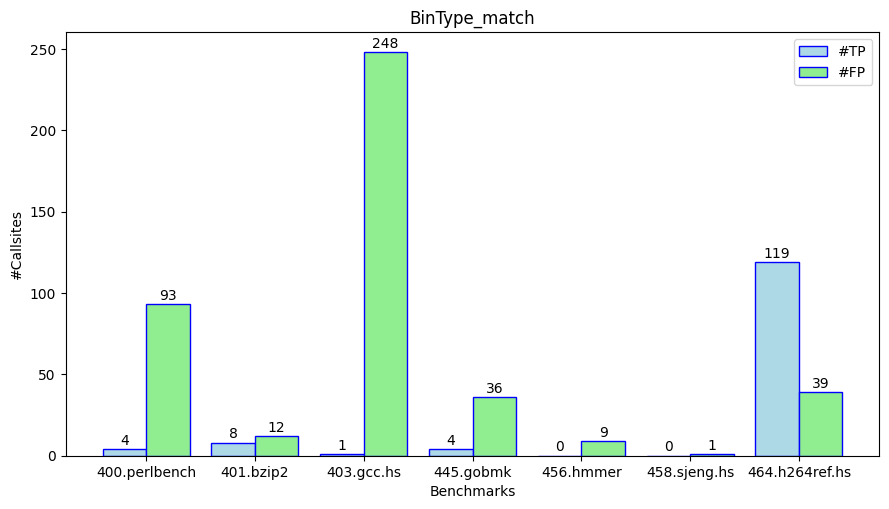

In [3]:
def matchPlot(match_type):
    match_count = {}
    for benchmark, df in clean_dict.items():
        match_count[benchmark] = df[match_type].value_counts().to_dict()
        if not 1 in match_count[benchmark]: match_count[benchmark][1] = 0
        if not 0 in match_count[benchmark]: match_count[benchmark][0] = 0

    # sorted by key, return a list of tuples
    lists = sorted(match_count.items())
    x, y = zip(*lists)
    y2, y1 = zip(*[[item[1] for item in sorted(li[1].items())] for li in lists])
    
    # Set the bar width.
    w = 0.4
    
    bar1 = np.arange(len(x))
    bar2 = [i+w for i in bar1]
    
    fig, ax = plt.subplots()
    
    fig.set_dpi(100)
    fig.set_size_inches(10.5, 5.5)
    
    color = ['red','blue','green','orange']
    
    ax_bar1 = ax.bar(bar1, y1,w, label="#TP", color="lightblue", edgecolor="b")
    ax_bar2 = ax.bar(bar2, y2,w, label="#FP", color="lightgreen", edgecolor="b")
    
    ax.set_xticks(bar1+w/2, x)
    ax.set_ylabel("#Callsites")
    ax.set_xlabel("Benchmarks")
    ax.set_title(match_type)
    ax.legend()
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height+1, \
                    '%d' % int(height), \
                    ha='center', va='bottom')
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    
    plt.show()
    plt.close(fig)

matchPlot("Param_match")

matchPlot("SrcType_match")

matchPlot("SafeSrcType_match")

matchPlot("BinType_match")

In [4]:
print("\\begin{table*}[t]")
print("\\centering")
def matchTable(match_type, match_type_ida):
    match_count = {}
    for benchmark, df in clean_dict.items():
        llvm_arr = df[match_type].to_numpy()
        ida_arr = df[match_type_ida].to_numpy()
        match_count[benchmark] = df[match_type].describe(percentiles=[.9]).to_list()
        match_count[benchmark].extend(df[match_type_ida].describe(percentiles=[.9]).to_list()[1:])
    headers = ["Benchmark", "Count", "Mean", "Std", "Min", "Med", "90thp", "Max", \
              "Mean", "Std", "Min", "Med", "90thp", "Max"]
    table = tabulate([[k]+[int(x) if not np.isnan(x) else x for x in v] for k,v in match_count.items()], \
                   headers=headers, tablefmt="latex")
    print("\\resizebox{\\columnwidth}{!}{")
    table = table.split("\n")
    # replace first row with custom latex statement.
    table[0] = "\\begin{tabular}[t]{|l|||r||r|r|r|r|r|r||r|r|r|r|r|r|r|}"
    # First print only two rows.
    [print(line) for line in table[:2]]
    print("\\multicolumn{2}{|c||}{} & \\multicolumn{6}{|c||}{LLVM-CFI} "
    "& \\multicolumn{6}{|c|}{Binary-CFI}\\\\")
    print("\\hline")
    [print(line) for line in table[2:]]
    print("}")

# matchTable("Param_match")

matchTable("BinType (TypeArmor)", "BinType (TypeArmor)_ida")

matchTable("SafeSrcType (IFCC-safe)", "SafeSrcType (IFCC-safe)_ida")

matchTable("SrcType (IFCC)", "SrcType (IFCC)_ida")

print("\caption{Comparison of 3 different policies ({\it TypeArmor}, {\it Safe IFCC}, {\it IFCC})"
              "applied for binaries compiled with debug symbols. "
               "The count depicts number of callsites, and subsequent columns display Mean, Standard "
               "Deviation, Minimum, Median, 90\\textsuperscript{th} percentile and Maximum aggregate "
               "results for each SPEC (Stripped) benchmark.}")
print("\\label{table:spec_stripped}")
print("\\end{table*}")

\begin{table*}[t]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}[t]{|l|||r||r|r|r|r|r|r||r|r|r|r|r|r|r|}
\hline
\multicolumn{2}{|c||}{} & \multicolumn{6}{|c||}{LLVM-CFI} & \multicolumn{6}{|c|}{Binary-CFI}\\
\hline
 Benchmark      &   Count &   Mean &   Std &   Min &   Med &   90thp &   Max &   Mean &   Std &   Min &   Med &   90thp &   Max \\
\hline
 400.perlbench  &      97 &    935 &   263 &   384 &  1055 &    1249 &  1293 &    625 &   291 &   194 &   594 &    1231 &  1293 \\
 401.bzip2      &      20 &     67 &     5 &    63 &    63 &      73 &    73 &     59 &    12 &    46 &    62 &      73 &    73 \\
 403.gcc.hs     &     249 &   1595 &   615 &   107 &  1891 &    2008 &  2920 &   1753 &   573 &   129 &  1814 &    2580 &  2920 \\
 445.gobmk      &      40 &   1625 &   844 &   214 &  2126 &    2165 &  2198 &   1504 &   714 &   203 &  1868 &    2198 &  2198 \\
 456.hmmer      &       9 &    226 &     0 &   226 &   226 &     226 &   226 &    221 &     0 &   221 &   221 &    

400.perlbench


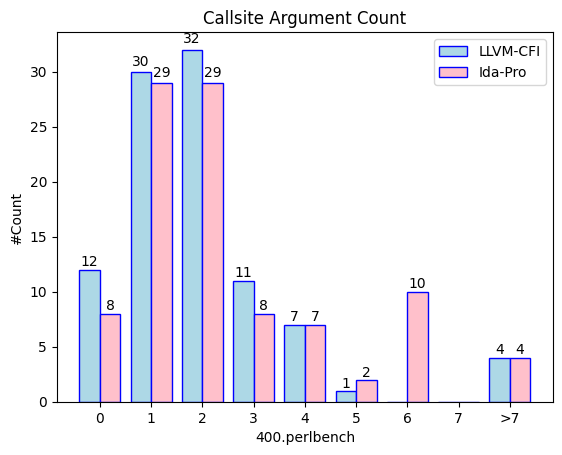

401.bzip2


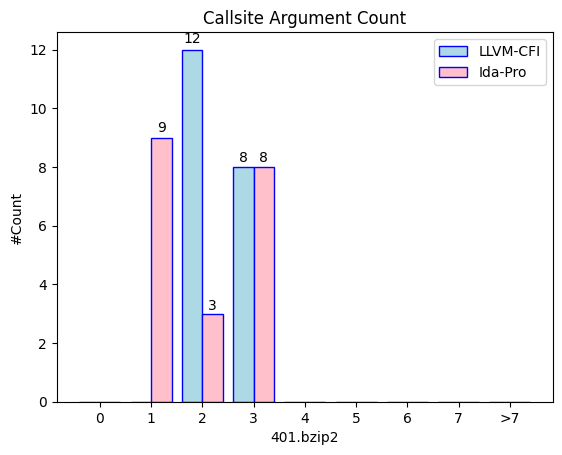

403.gcc.hs


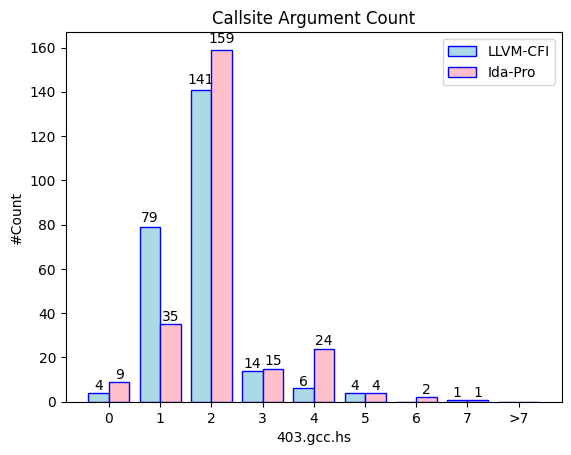

445.gobmk


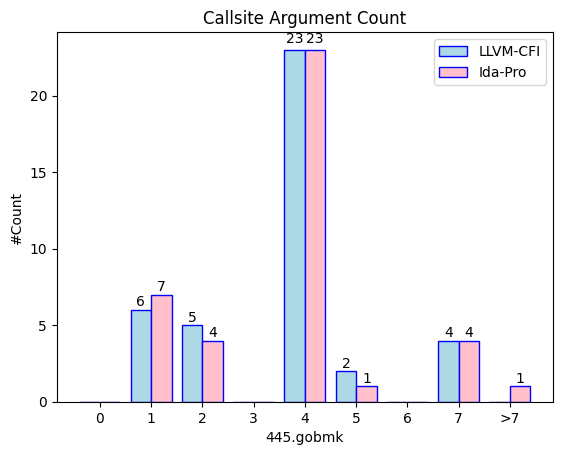

456.hmmer


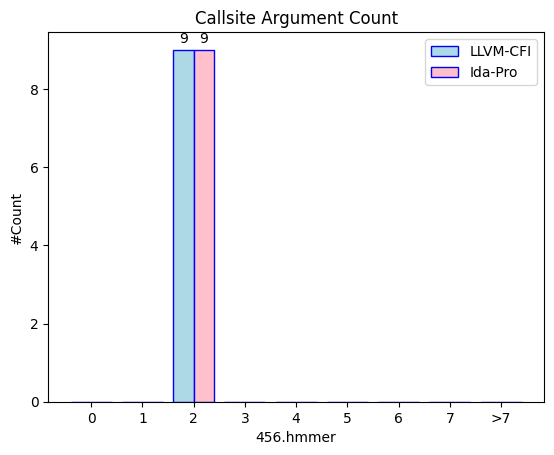

458.sjeng.hs


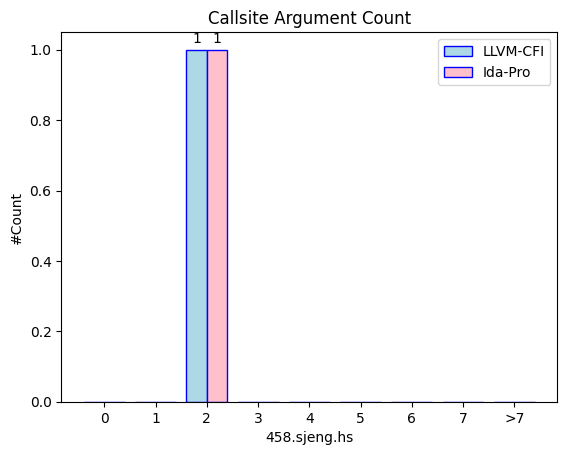

464.h264ref.hs


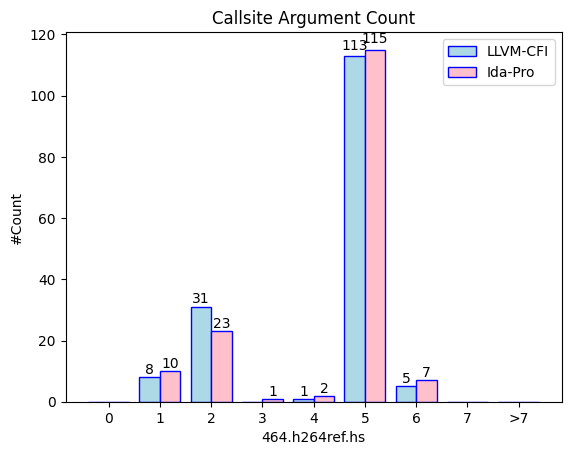

In [5]:
def paramPlot(benchmark, df):
    params = df["Params"].value_counts().to_dict()
    more_than_seven = 0
    for k in list(params.keys()):
        if k > 7: more_than_seven += params.pop(k)
    params[">7"] = more_than_seven
    ida_params = df["Params_ida"].value_counts().to_dict()
    more_than_seven = 0
    for k in list(ida_params.keys()):
        if k > 7: more_than_seven += ida_params.pop(k)
    ida_params[">7"] = more_than_seven
    
    # Add missing keys.
    for k in range(8):
        if k not in params:
            params[k] = 0
        if k not in ida_params:
            ida_params[k] = 0
    
    # Sort dictionaries with keys, as one of the keys is ">7" and is a string,
    # convert rest of the keys into string and then sort.
    y1 = [item[1] for item in sorted(map(lambda x: [str(x[0]),x[1]], params.items()))]
    y2 = [item[1] for item in sorted(map(lambda x: [str(x[0]),x[1]], ida_params.items()))]
    
    x = [item[0] for item in sorted(map(lambda x: [str(x[0]),x[1]], params.items()))]
    
    # Set the bar width.
    w = 0.4
    
    bar1 = np.arange(len(x))
    bar2 = [i+w for i in bar1]
    
    fig, ax = plt.subplots()
    fig.set_dpi(100)
    
    color = ['red','blue','green','orange']
    
    ax_bar1 = ax.bar(bar1, y1, w, label="LLVM-CFI", color="lightblue", edgecolor="b")
    ax_bar2 = ax.bar(bar2, y2, w, label="Ida-Pro", color="pink", edgecolor="b")
    
    ax.set_xticks(bar1+w/2, x)
    ax.set_ylabel("#Count")
    ax.set_xlabel(benchmark)
    ax.set_title("Callsite Argument Count")
    ax.legend()
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            # Don't print the label if the height of the bar is zero.
            if height == 0: continue
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, \
                    '%d' % int(height), \
                    ha='center', va='bottom')
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    
    plt.show()
    plt.close(fig)

for benchmark, df in clean_dict.items():
    print(benchmark)
    paramPlot(benchmark, df)

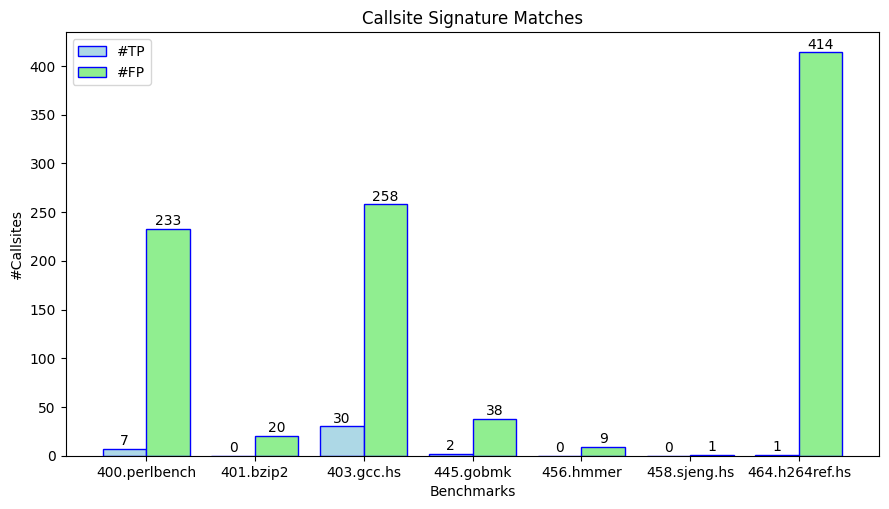

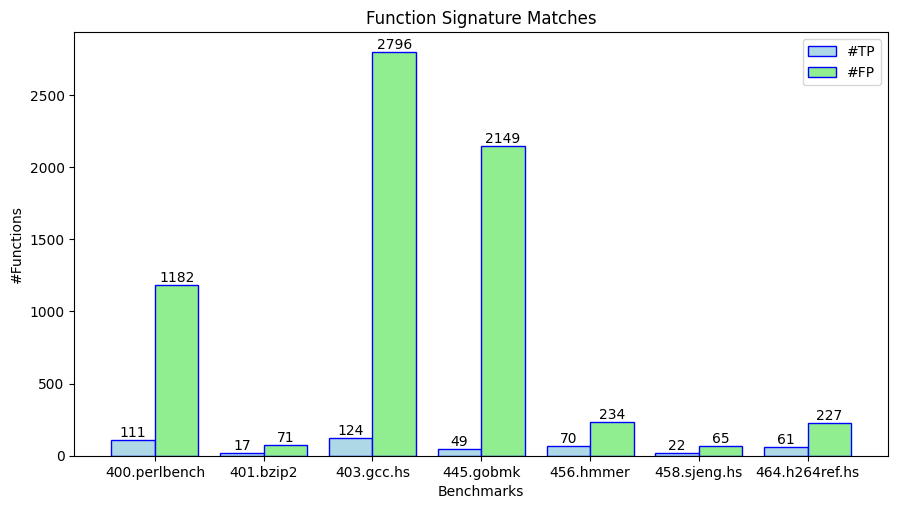

In [6]:
def signaturePlot(graph_type):
    if graph_type == "Callsite":
        dic = callsite_dict
    else:
        dic = fun_dict
    
    cols = ["Arg1", "Arg2", "Arg3", "Arg4", "Arg5", \
               "Arg6", "Arg7", "Return"]
    cols_ida = ["Arg1_ida", "Arg2_ida", "Arg3_ida", "Arg4_ida", "Arg5_ida", \
               "Arg6_ida", "Arg7_ida", "Return_ida"]
    match_count = {}
    for benchmark, df in dic.items():
        match_count[benchmark] = (df[cols].values == df[cols_ida].values).all(axis=1).astype(int)
        match_count[benchmark] = dict(zip(*np.unique(match_count[benchmark], return_counts=True)))
        if not 1 in match_count[benchmark]: match_count[benchmark][1] = 0
        if not 0 in match_count[benchmark]: match_count[benchmark][0] = 0

    # sorted by key, return a list of tuples
    lists = sorted(match_count.items())
    x, y = zip(*lists)
    y2, y1 = zip(*[[item[1] for item in sorted(li[1].items())] for li in lists])
    
    # Set the bar width.
    w = 0.4
    
    bar1 = np.arange(len(x))
    bar2 = [i+w for i in bar1]
    
    fig, ax = plt.subplots()
    
    fig.set_dpi(100)
    fig.set_size_inches(10.5, 5.5)
    
    color = ['red','blue','green','orange']
    
    ax_bar1 = ax.bar(bar1, y1,w, label="#TP", color="lightblue", edgecolor="b")
    ax_bar2 = ax.bar(bar2, y2,w, label="#FP", color="lightgreen", edgecolor="b")
    
    ax.set_xticks(bar1+w/2, x)
    ax.set_ylabel(f"#{graph_type}s")
    ax.set_xlabel("Benchmarks")
    ax.set_title(f"{graph_type} Signature Matches")
    ax.legend()
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height+1, \
                    '%d' % int(height), \
                    ha='center', va='bottom')
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    
    plt.show()
    plt.close(fig)
signaturePlot("Callsite")
signaturePlot("Function")

In [7]:
path = "/volatile/zephyr/Ruturaj/cfi_project/test_suite/spec-stripped/"
benchmarks = ["400.perlbench", "401.bzip2", "403.gcc.hs", "445.gobmk", "456.hmmer", \
              "458.sjeng.hs", "464.h264ref.hs"]
binaries = ["perlbench-debug.exe", "bzip2.exe", "gcc.exe", "gobmk.exe", "hmmer.exe", \
            "sjeng.exe", "h264ref.exe"]

metric_dict = {}

def convertDwarf(dwarf):
    return ":".join(dwarf.split(":", 2)[:2])

def addr2line(bin, path, df) -> list:
    dwarf = []
    for _,row in df.iterrows():
        cmd = ["addr2line", "-e", bin, "-f", row.iloc[0]]
        dwarflines = subprocess.check_output(cmd)
        function, dwarfline = dwarflines.splitlines()
        if function.decode() == "??" or dwarfline.decode() == "??:?":
            dwarf.append(np.nan)
            continue
        # Remove **(discriminator 7)** which appears in addr2line output.
        # For e.g. perlio.c:1375 (discriminator 7).
        dwarfline = dwarfline.split()[0]
        dwarf.append(dwarfline.decode().split(path.split("/")[-1])[-1][1:])
    return dwarf

def iterateRows(df, index):
    dic = {}
    for _,row in df.iterrows():
        k = row.iloc[0]
        dic[k] = {"ifcc":set(), "ifccsafe":set(), "typearmor":set()}
        # Extract number of functions for IFCC approach.
        # IFCC functions start from "18" column for llvm and "19" for ida,
        # which is well known seeing the dataframes.
        # Thus first calculate IFCC functions and then look for the others.
        idx = index
        ifcc_funs = int(row.iloc[idx][row.iloc[idx].find("(")+1:row.iloc[idx].find(")")])
        for i in range(idx+1, idx+ifcc_funs+1):
            dic[k]["ifcc"].add(row.iloc[i])
        idx = idx + ifcc_funs + 1
        ifccsafe_funs = int(row.iloc[idx][row.iloc[idx].find("(")+1:row.iloc[idx].find(")")])
        for i in range(idx+1, idx+ifccsafe_funs+1):
            dic[k]["ifccsafe"].add(row.iloc[i])
        idx = idx + ifccsafe_funs + 1
        typearmor_funs = int(row.iloc[idx][row.iloc[idx].find("(")+1:row.iloc[idx].find(")")])
        for i in range(idx+1, idx+typearmor_funs+1):
            dic[k]["typearmor"].add(row.iloc[i])
    return dic

for i, benchmark in enumerate(benchmarks):
    print(benchmark)
    
    delimiter = ','
    max_columns = max(open(os.path.join(path+benchmark+"/SDOutput", binaries[i] + \
                            "-Indirect-metric.csv"), 'r'), key = lambda x: x.count(delimiter)).count(delimiter)
    metric_df = pd.read_csv(os.path.join(path+benchmark+"/SDOutput", binaries[i] + \
                            "-Indirect-metric.csv"),\
                            sep=',', lineterminator='\n', names = list(range(0,max_columns+1)),\
                           skiprows=[0,1])
    metric_df.iloc[:,0] = metric_df.iloc[:,0].apply(convertDwarf)
    
    max_columns = max(open(os.path.join(path+benchmark+"/IDAoutput", binaries[i] + \
                            "-Indirect-metric.csv"), 'r'), key = lambda x: x.count(delimiter)).count(delimiter)
    ida_metric_df = pd.read_csv(os.path.join(path+benchmark+"/IDAoutput", binaries[i] + \
                            "-Indirect-metric.csv"),\
                            sep=',', lineterminator='\n', names = list(range(0,max_columns+1)), \
                               dtype=object, skiprows=[0,1])
    
    # Compute dwarf information using addr2line tool for ida generated df.
    # The first argument will always be a binary with debug information - thus using replace.
    dwarf = addr2line(os.path.join(path.replace("spec-stripped", "spec"), benchmark+"/"+binaries[i]), \
                      os.path.join(path, benchmark), ida_metric_df)
    ida_metric_df.insert(loc=0, column=("Dwarf"), value=dwarf)
    
    metric_dict[benchmark] = {}
    metric_dict[benchmark]["llvm"] = iterateRows(metric_df, 18)
    metric_dict[benchmark]["ida"] = iterateRows(ida_metric_df, 19)
    metric_dict[benchmark]["baseline_llvm"] = metric_df.iloc[:1,10][0]
    metric_dict[benchmark]["baseline_ida"] = int(ida_metric_df.iloc[:1,11][0])

400.perlbench
401.bzip2
403.gcc.hs


/tmp/ipykernel_739108/712475985.py:56: DtypeWarning: Columns (2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946) have mixed types. Specify dtype option on import or set low_memory=False.
  metric_df = pd.read_csv(os.path.join(path+benchmark+"/SDOutput", binaries[i] + \


445.gobmk
456.hmmer
458.sjeng.hs
464.h264ref.hs


400.perlbench


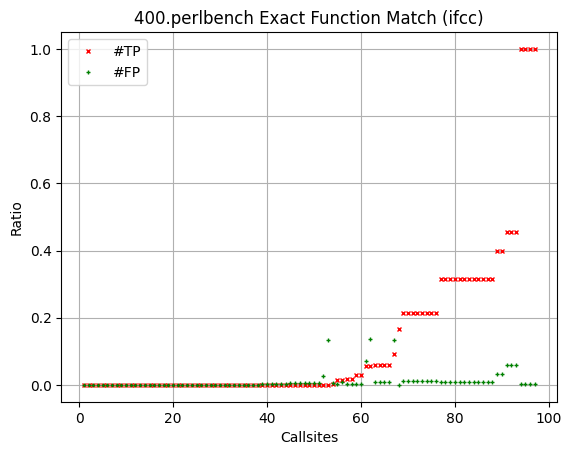

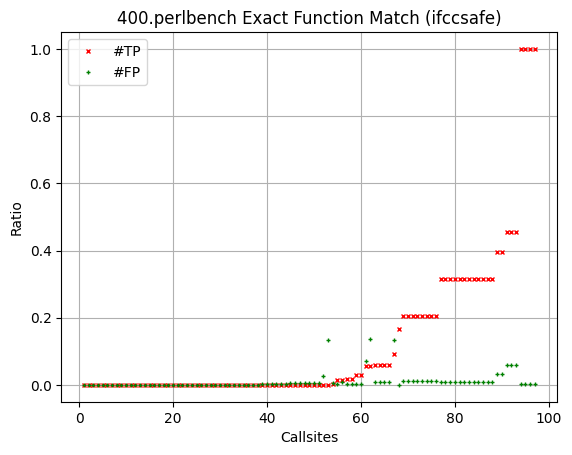

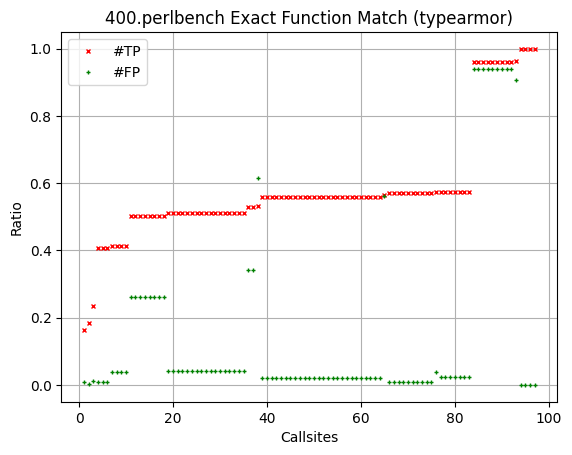

401.bzip2


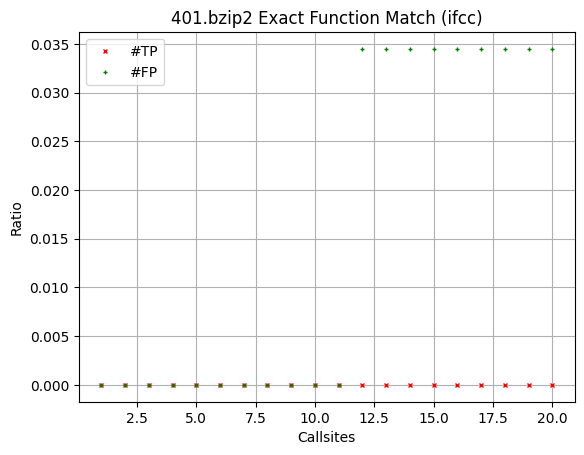

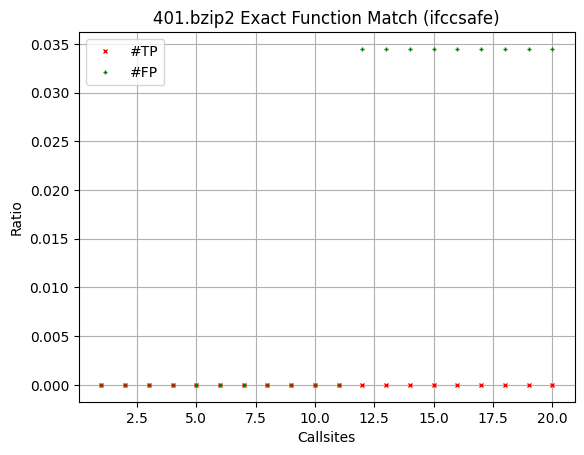

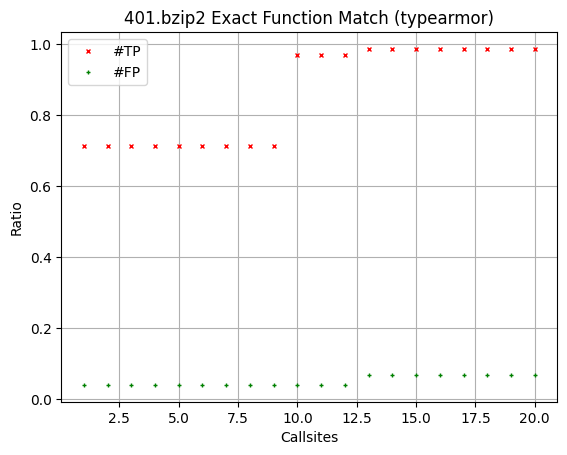

403.gcc.hs


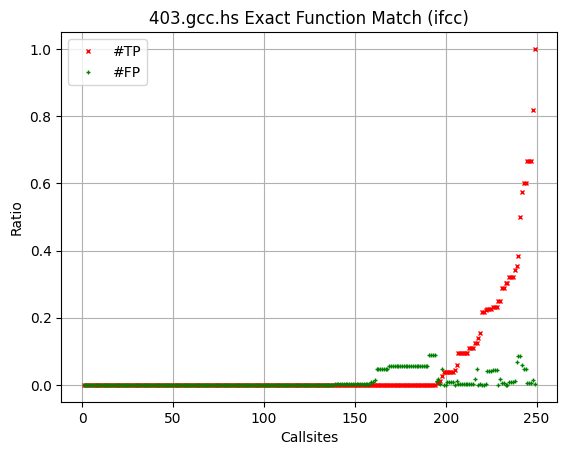

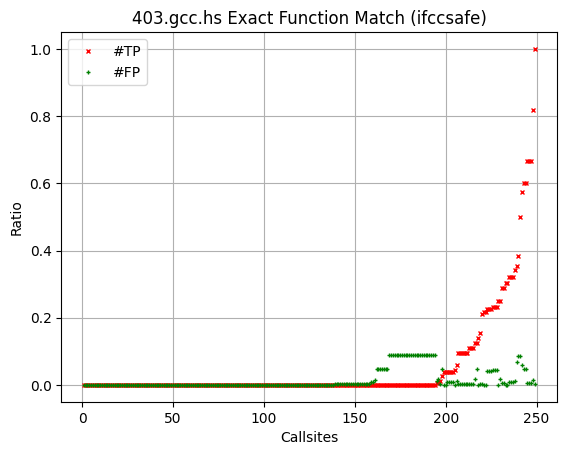

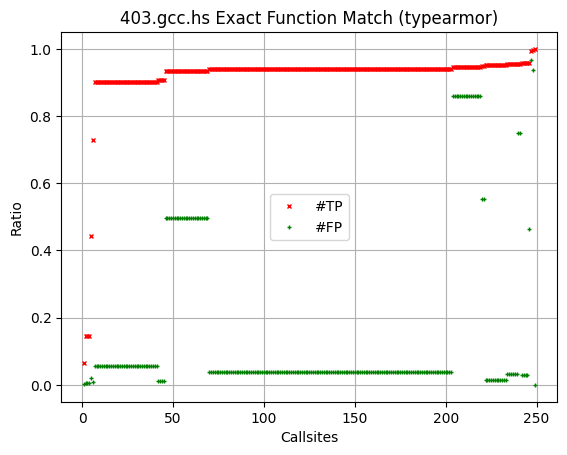

445.gobmk


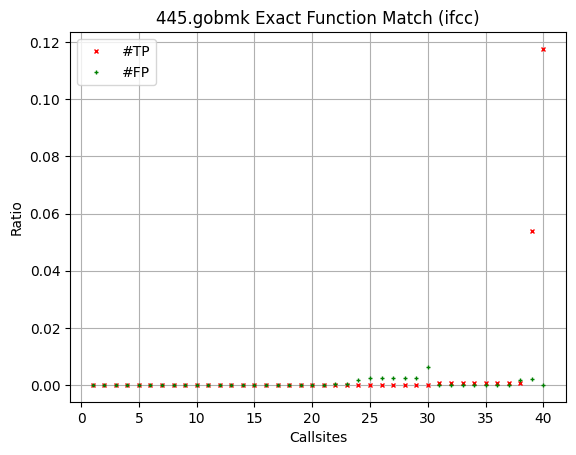

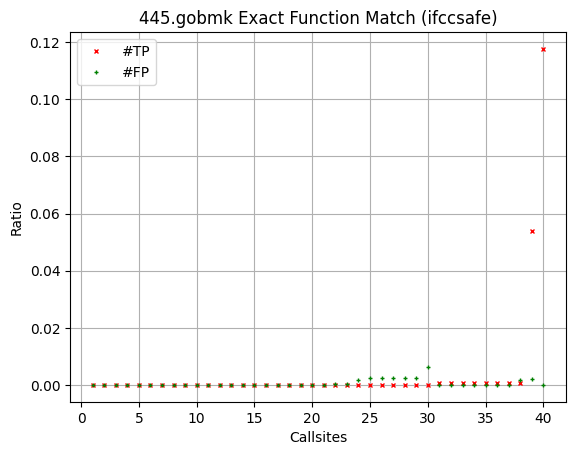

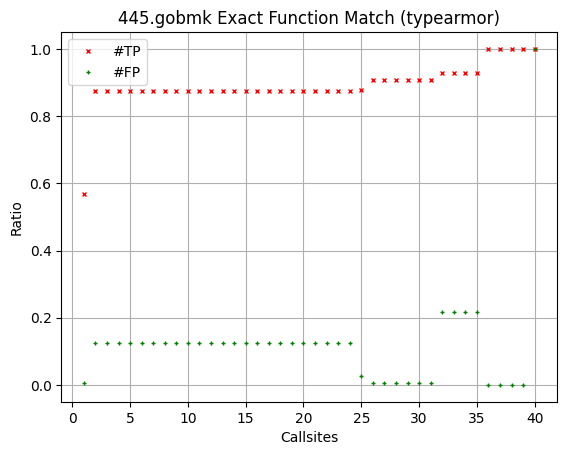

456.hmmer


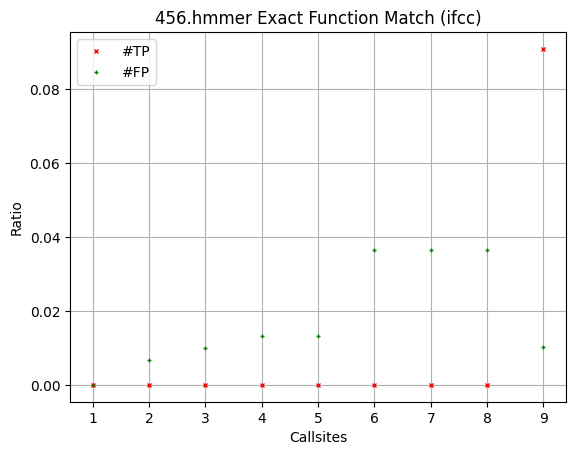

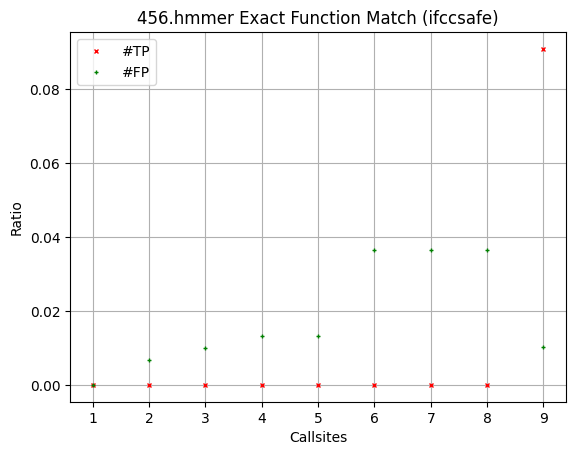

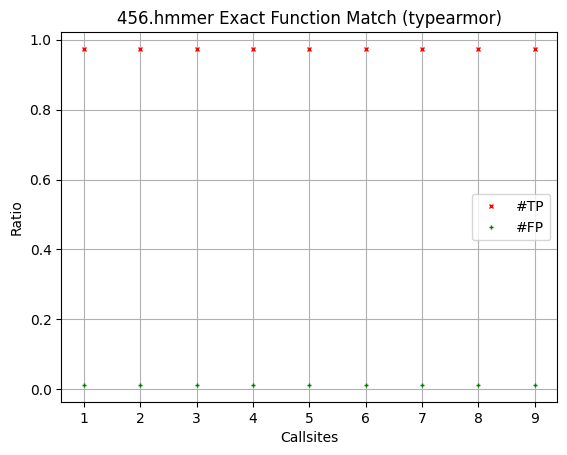

458.sjeng.hs


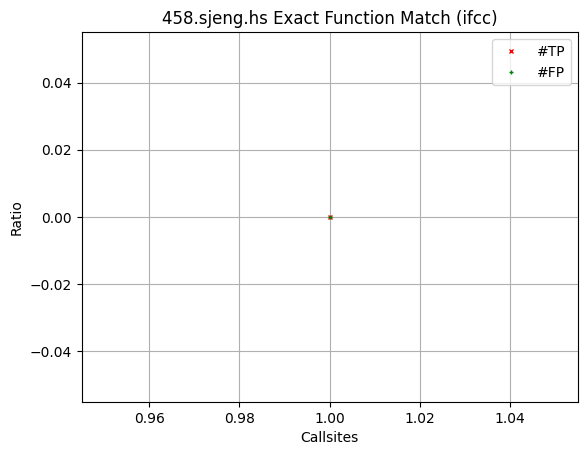

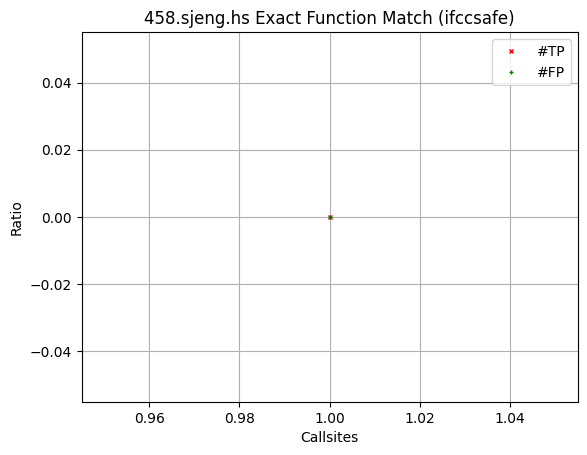

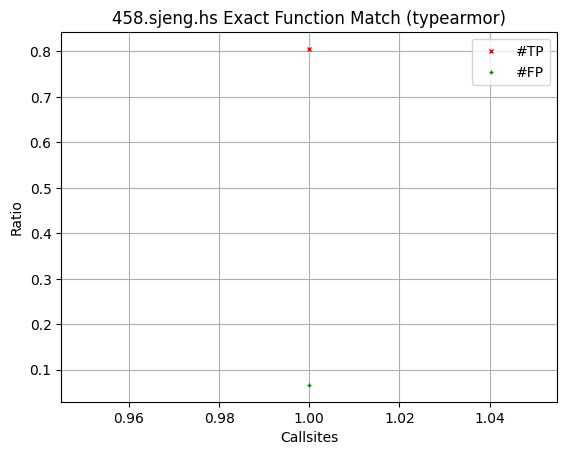

464.h264ref.hs


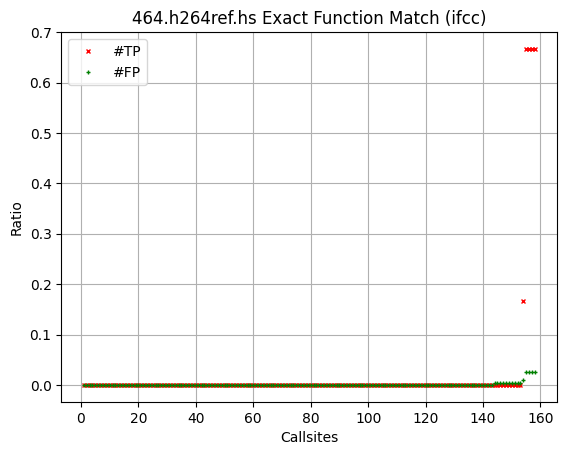

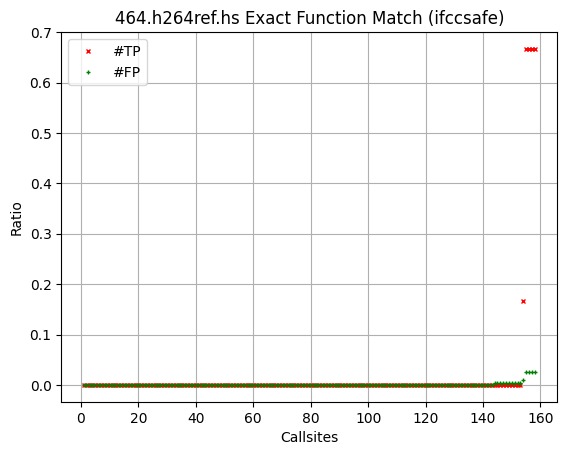

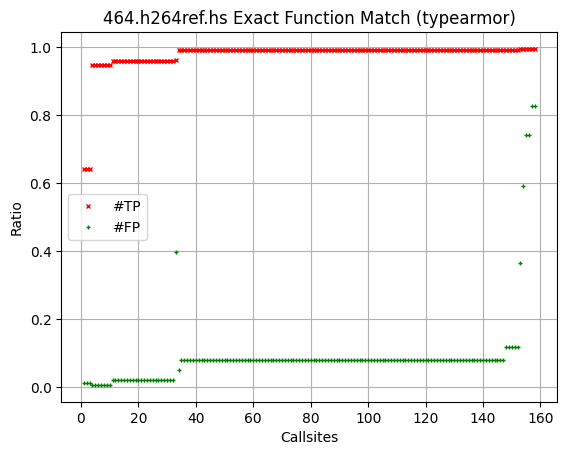

In [8]:
def exactMatchPlot():
    model_stat = {}
    for benchmark, graph_type in metric_dict.items():
        print(benchmark)
        model_stat[benchmark] = {"ifcc":{"tp":[],"tn":[], "fp":[]}, \
                                 "ifccsafe":{"tp":[],"tn":[], "fp":[]},\
                                 "typearmor":{"tp":[],"tn":[], "fp":[]}}
        for callsite, models in graph_type["ida"].items():
            if callsite in graph_type["llvm"]:
                # ifcc model
                # if no function is allowed at callsite, then check whether
                # ida displays then mark both tp and tn 0.
                if len(graph_type["llvm"][callsite]["ifcc"]) == 0:
                    model_stat[benchmark]["ifcc"]["tp"].append(0)
                    model_stat[benchmark]["ifcc"]["tn"].append(0)
                else:
                    model_stat[benchmark]["ifcc"]["tp"]\
                    .append(len(models["ifcc"]&graph_type["llvm"][callsite]["ifcc"])\
                            /len(graph_type["llvm"][callsite]["ifcc"]))
                    model_stat[benchmark]["ifcc"]["tn"]\
                    .append(len(graph_type["llvm"][callsite]["ifcc"]-models["ifcc"])\
                           /len(graph_type["llvm"][callsite]["ifcc"]))
                numerator = graph_type["baseline_llvm"]-len(graph_type["llvm"][callsite]["ifcc"])
                if numerator == 0:
                    model_stat[benchmark]["ifcc"]["fp"].append(0)
                else:
                    model_stat[benchmark]["ifcc"]["fp"]\
                    .append(len(models["ifcc"]-graph_type["llvm"][callsite]["ifcc"])\
                           /numerator)
                
                # ifccsafe model
                # if no function is allowed at callsite, then check whether
                # ida displays the same if not then it is a false negative.
                if len(graph_type["llvm"][callsite]["ifccsafe"]) == 0:
                    model_stat[benchmark]["ifccsafe"]["tp"].append(0)
                    model_stat[benchmark]["ifccsafe"]["tn"].append(0)
                else:
                    model_stat[benchmark]["ifccsafe"]["tp"]\
                    .append(len(models["ifccsafe"]&graph_type["llvm"][callsite]["ifccsafe"])\
                            /len(graph_type["llvm"][callsite]["ifccsafe"]))
                    model_stat[benchmark]["ifccsafe"]["tn"]\
                    .append(len(graph_type["llvm"][callsite]["ifccsafe"]-models["ifccsafe"])\
                           /len(graph_type["llvm"][callsite]["ifccsafe"]))
                numerator = graph_type["baseline_llvm"]-len(graph_type["llvm"][callsite]["ifccsafe"])
                if numerator == 0:
                    model_stat[benchmark]["ifccsafe"]["fp"].append(0)
                else:
                    model_stat[benchmark]["ifccsafe"]["fp"]\
                    .append(len(models["ifccsafe"]-graph_type["llvm"][callsite]["ifccsafe"])\
                           /numerator)
                
                # typearmor model
                model_stat[benchmark]["typearmor"]["tp"]\
                .append(len(models["typearmor"]&graph_type["llvm"][callsite]["typearmor"])\
                        /len(graph_type["llvm"][callsite]["typearmor"]))
                model_stat[benchmark]["typearmor"]["tn"]\
                .append(len(graph_type["llvm"][callsite]["typearmor"]-models["typearmor"])\
                       /len(graph_type["llvm"][callsite]["typearmor"]))
                numerator = graph_type["baseline_llvm"]-len(graph_type["llvm"][callsite]["typearmor"])
                if numerator == 0:
                    model_stat[benchmark]["typearmor"]["fp"].append(0)
                else:
                    model_stat[benchmark]["typearmor"]["fp"]\
                    .append(len(models["typearmor"]-graph_type["llvm"][callsite]["typearmor"])\
                           /numerator)

        for model in ["ifcc", "ifccsafe", "typearmor"]:
            y1 = sorted(model_stat[benchmark][model]["tp"])
            _,y2 = zip(*sorted(zip(model_stat[benchmark][model]["tp"], model_stat[benchmark][model]["tn"])))
            _,y3 = zip(*sorted(zip(model_stat[benchmark][model]["tp"], model_stat[benchmark][model]["fp"])))

            bar1 = np.arange(1,len(y1)+1)
            bar2 = np.arange(1,len(y2)+1)
            bar3 = np.arange(1,len(y3)+1)

            fig, ax = plt.subplots()

            fig.set_dpi(100)

            color = ['red','blue','green','orange']

            ax_bar1 = ax.plot(bar1, y1, label="#TP", linestyle='None', marker = "x", markersize=3, color="r")
            #ax_bar2 = ax.plot(bar2, y2, label="#TN")
            ax_bar3 = ax.plot(bar3, y3, label="#FP", linestyle='None', marker = "+", markersize=3, color="g")

            # ax.set_xticks(bar1, x)
            ax.set_ylabel("Ratio")
            ax.set_xlabel("Callsites")
            ax.set_title(f"{benchmark} Exact Function Match ({model})")
            ax.legend()
            ax.grid(axis='both', which='both')
            plt.show()
            plt.close(fig)

exactMatchPlot()